## Exercício

_"Uma cavidade ressonante, ilustrada na figura abaixo, tem todas as paredes elétricas e é
preenchida com material FR-4 (&epsilon;<sub>r</sub> = 4,4 e tg&delta; = 0,02). As paredes são constituídas de
cobre com condutividade &sigma;=5,8x10<sup></sup> S/m.
Dados: A = B = 45,95 mm e h = 1,6 mm."_

Abaixo vamos salvar tais constantes:

In [1]:
# Problem constants to be matched with the ones above

A = 45.95e-3
B = A
h = 1.6e-3

epsilon_r = 4.4
loss_tangent = 0.02
condutancy = 5.8e7

#### Pede-se:

#### a) A frequência do primeiro modo de ressonância (modo dominante).

Como somos preguiçosos [vamos pedir ajuda do ChatGPT](https://chat.openai.com/share/52cbc312-9e6c-45a0-bc1c-7e655c02dd74) para escrever a fórmula da frequência de um modo m, n, l de um condutor. Como os modos são dados pelos eixos x, y e z, vamos utilizar esse valor na fórmula da frequência:
 
$f = \frac{c}{2\pi \sqrt{\mu_r \epsilon_r}} \sqrt{\left(\frac{m}{x}\right)^2 + \left(\frac{n}{y}\right)^2 + \left(\frac{l}{z}\right)^2}$

Logo, para obtermos o modo com a menor frequência de ressonância (também chamado de **modo dominante**), precisamos dos menores coeficientes de modo (m, n, l) possíveis, que são 0 e 1, pareados respectivamente com as menores e maiores dimensões, dado que precisamos de pelo menos dois valores não nulos (logo, iguais a 1). O modo dominante é portanto 110 (não importa se é TE ou TM; será? enfim).

Para calcularmos f<sub>110</sub>, vamos primeiramente importar as bibliotecas, acertar configurações e inicializar as constantes:

In [2]:
# General imports needed

import numpy as np
from scipy import constants
import matplotlib.pyplot as plt
from mpl_smithchart import SmithAxes

In [3]:
# Saving configuration (what great comment, isn't it?)

save = True

In [4]:
# Real world constants

c = constants.speed_of_light
pi = constants.pi
epsilon_0 = constants.epsilon_0
mu_0 = constants.mu_0

Agora sim podemos criar a classe que vai representar uma cavidade ressonante retangular e calcular algumas quantidades de interesse:

In [5]:
# Class representing a rectangular resonator
#
# todo: implement the field equations with SymPy and derive the results symbolically, like the fields of mode 'mnl'

class RectangularResonator(object):
    def __init__(self, x, y, z, epsilon_r, mu_r, loss_tangent, condutancy):
        self.x = x
        self.y = y
        self.z = z
        self.epsilon_r = epsilon_r
        self.mu_r = mu_r
        self.loss_tangent = loss_tangent
        self.condutancy = condutancy
        self.dimensions = self.sort_dimensions()
        self.dominant_mode = self.get_dominant_mode()

    def sort_dimensions(self):
        dimensions = [
            {'dimension': 'x', 'value': self.x},
            {'dimension': 'y', 'value': self.y},
            {'dimension': 'z', 'value': self.z},
        ]

        return sorted(dimensions, key=lambda obj: obj['value'])
    
    def k(self, m, n, l):
        return np.sqrt((m * pi / self.x)**2 + (n * pi / self.y)**2 + (l * pi / self.z)**2)

    def frequency(self, m, n, l):
        k = self.k(m, n, l)
        return (c * k)/(2*pi * np.sqrt(self.epsilon_r * self.mu_r))

    def get_dominant_mode(self):
        position_encoding = {
            'x': 0,
            'y': 1,
            'z': 2,
        }
        
        mode = [0, 0, 0]
        for i, dim in enumerate(self.dimensions):
            if i != 0:
                mode[position_encoding[dim['dimension']]] = 1
    
        f = self.frequency(*mode)

        return {'mode': mode, 'frequency': f, 'frequency_formated': self.format_e(f)}


    def format_e(self, n):
        a = '%E' % n
        return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]


Vamos agora instanciar um objeto dessa classe representando o problema em questão e obter a frequência do modo dominante:

In [6]:
resonator = RectangularResonator(A, B, h, epsilon_r, 1, loss_tangent, condutancy)
resonator.dominant_mode

{'mode': [1, 1, 0],
 'frequency': 2199347485.866347,
 'frequency_formated': '2.199347E+09'}

**f<sub>110</sub> = 2,199 GHz**

---

#### c) O fator de qualidade do modo dominante.

Sabemos que:

$\frac{1}{Q} = \frac{1}{Q_d} + \frac{1}{Q_c}$

$Qd = \frac{1}{\tan \delta}$

$Q_c = \frac{a b (a^2 + b^2) h}{(a b^3 + 2 b^3 h + a^3 (b + 2 h)) \Delta}$

$\Delta = (\pi f_{110} \mu_0 \sigma)^{-\frac{1}{2}}$

In [7]:
def get_quality_factor_dominant_mode(resonator):
    Qd = 1/resonator.loss_tangent
    
    delta = 1/np.sqrt(pi * resonator.dominant_mode['frequency'] * resonator.mu_r * mu_0 * resonator.condutancy)
    Qc_den = (resonator.x * resonator.y**3 + 2 * resonator.y**3 * resonator.z + resonator.x**3 * (resonator.y + 2 * resonator.z)) * delta
    Qc_num = resonator.x * resonator.y * (resonator.x**2 + resonator.y**2) * resonator.z
    Qc = Qc_num/Qc_den

    Q = 1/(1/Qd + 1/Qc)

    return Q

Q = get_quality_factor_dominant_mode(resonator)
Q # 47.75080091766975

47.75080091766975

**Q = 47,7**

---

#### d) Se a excitação for realizada de forma que a resistência de entrada da cavidade seja igual a 50 Ω na ressonância, quais os valores dos componentes L e C para o circuito RLC paralelo equivalente?

Para uma cavidade ressonante retangular o circuito que a representa é do tipo RLC paralelo, cuja expressão da impedância de entrada é:

$Z_{in} = (\frac{1}{R} + \frac{1}{jwL} + jwC)^{-1}$

Outra possível expressão para Z<sub>in</sub> é:

$Z_{in} = \frac{P_{loss} + 2jw(W_m - W_e)}{\frac{1}{2}\vert I \vert ^2}$

A ressonância acontece quando W<sub>m</sub> = W<sub>e</sub>, o que nos leva a:

$Z_{in} = R$

No presente caso o enunciado nos dá Z<sub>in</sub> = R = 50 &Omega;, restando apenas a determinação de L e C.

Da igualdade das energias elétrica e magnética na frequência de ressonância w<sub>0</sub>, temos:

$W_m = \frac{1}{4} \vert I\vert ^2 L = W_e = \frac{1}{4} \vert I \vert ^2 \frac{1}{w_0^2C}$

$w_0 = \frac{1}{\sqrt{LC}}$

Por fim, sabemos também que o fator de qualidade do RLC paralelo é:

$Q = w_0 \frac{2 W_m}{P_{loss}} = \frac{w_0 L}{R} = \frac{1}{w_0 R C}$

Calculando os valores de L e C temos:

In [8]:
R = 50
w0 = 2*pi * resonator.dominant_mode['frequency']
L = R / (w0 * Q)
C = 1 / (w0**2 * L)
L, C # (7.577319931103823e-11, 6.910937040629139e-11)

(7.577319931103823e-11, 6.910937040629139e-11)

**L = 75,8 pH** **C=69,1 pF**

---

**e)Assumindo que a cavidade ressonante é excitada por uma prova coaxial, uma reatância indutância série (XL) é incorporada à impedância de entrada, conduzindo ao seguinte circuito equivalente:**

O modelo para a indutância em série X<sub>L</sub> é dado por:

$X_L = if\mu_0h[ln(\frac{2}{k_0 r \sqrt{\epsilon_r}}) - 0,57721]$

Onde r = 0,65 mm

In [19]:
def X_L(f, r = 0.65e-3):
    multiplier = f * mu_0 * h
    k0 = condutancy * np.sqrt(mu_0 * epsilon_0)
    X_L = 1j * multiplier * (np.log(2/(k0 * r * np.sqrt(epsilon_r))) - 0.57721)
    return X_L

f = resonator.dominant_mode['frequency']
X_L(f) # 36.95207135743512j

36.95207135743512j

**X<sub>L</sub> = 36,95j**

---

**f) Computar a impedância de entrada da cavidade versus frequência, considerando o modelo apresentado no item (e). Traçar essa curva em uma carta de Smith e em um gráfico retangular. Considere uma banda de 150 MHz.**

Vamos computar a impedância de entrada Z<sub>in</sub> com dois modelos diferentes: uma aproximação em torno da frequência de ressonância w<sub>0</sub> e o valor exato.

- **Cálculo por aproximação**
 
$Z_{in} \approx \frac{R}{1 + 2 j Q_0 \Delta w / w_0}$

In [28]:
# Approximation near w0

R = 50
f0 = resonator.dominant_mode['frequency']
w0 = f0 * (2*pi)
Q = get_quality_factor_dominant_mode(resonator)
L = R / (w0 * Q)
C = 1 / (w0**2 * L)

def calculate_Z_in_near_resonance(delta_w):
    Z_in_unloaded = R / (1 + 2j * Q * delta_w/w0)

    w = delta_w
    f = w / (2*pi)
    Z_in = X_L(f) + Z_in_unloaded

    return Z_in

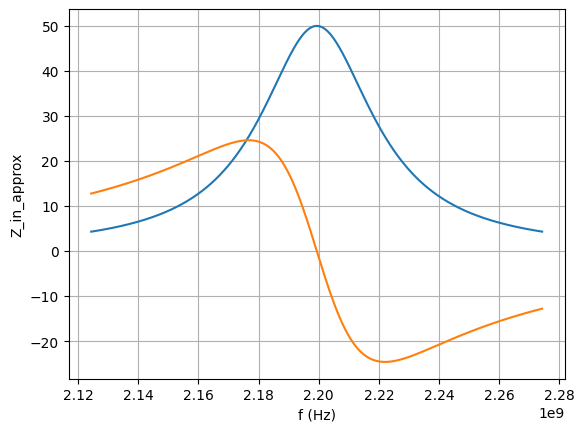

In [33]:
# Rectangular plot

delta_f = np.arange(-150e6/2, 150e6/2, 1e5)
delta_w = delta_f * (2*pi)
Z_in_near_resonance = calculate_Z_in_near_resonance(delta_w)

fig, ax = plt.subplots()
ax.plot(delta_f + f0, Z_in_near_resonance.real)
ax.plot(delta_f + f0, Z_in_near_resonance.imag)
ax.set(xlabel='f (Hz)', ylabel='Z_in_approx')
ax.grid()


if save:
    plt.savefig("Z_in_near_resonance_rectangular.png")

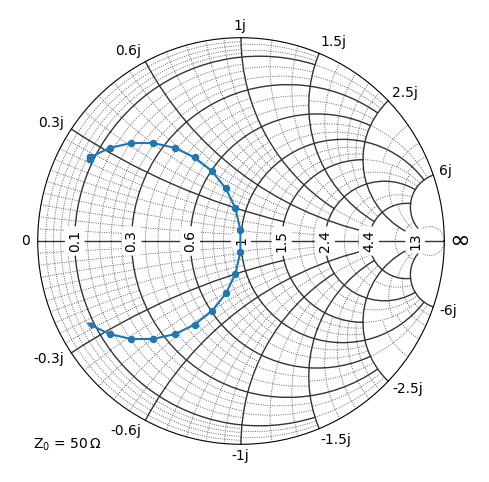

In [34]:
# Smith plot

plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1, projection='smith')
plt.plot(Z_in_near_resonance, equipoints=20, datatype=SmithAxes.Z_PARAMETER)

if save:
    plt.savefig("Z_in_near_resonance_smith.png")

- **Cálculo do valor exato**:

$Z_{in} = (\frac{1}{R} + \frac{1}{jwL} + jwC)^{-1}$


In [35]:
# Exact value

R = 50
f0 = resonator.dominant_mode['frequency']
w0 = f0 * (2*pi)
Q = get_quality_factor_dominant_mode(resonator)
L = R / (w0 * Q)
C = 1 / (w0**2 * L)

def calculate_Z_in(w):
    Z_in_inv = (1/R + 1/(1j * w * L) + 1j * w * C)
    return 1/Z_in_inv

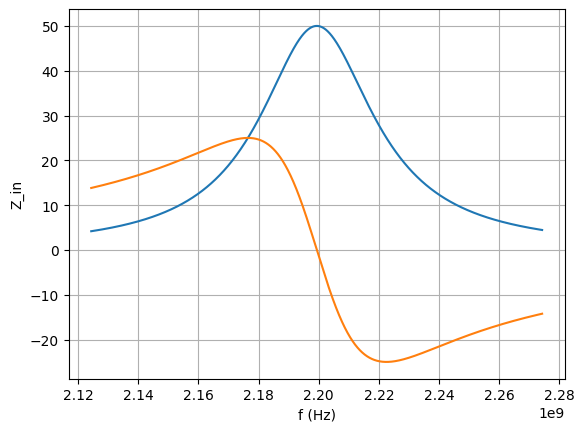

In [37]:
# Rectangular plot

f = np.arange(f0 - 150e6/2, f0 + 150e6/2, 1e5)
w = f * (2*pi)
Z_in = calculate_Z_in(w)

fig, ax = plt.subplots()
ax.plot(f, Z_in.real)
ax.plot(f, Z_in.imag)
ax.set(xlabel='f (Hz)', ylabel='Z_in')
ax.grid()


if save:
    plt.savefig("Z_in_rectangular.png")

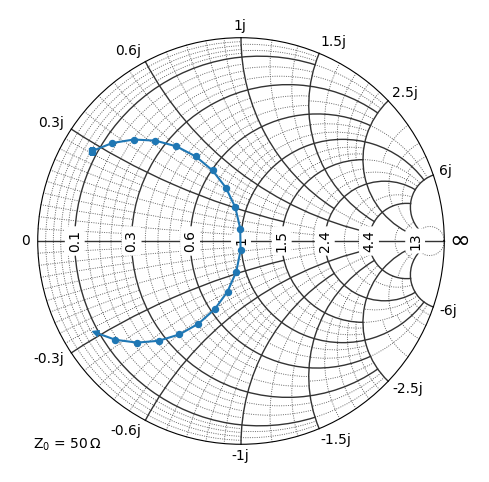

In [26]:
# Smith plot

plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1, projection='smith')
plt.plot(Z_in, equipoints=20, datatype=SmithAxes.Z_PARAMETER)

if save:
    plt.savefig("Z_in_smith.png")

Comparando as duas abordagens podemos gerar o seguinte gráfico de Z<sub>in</sub> - Z<sub>in_approx</sub>:

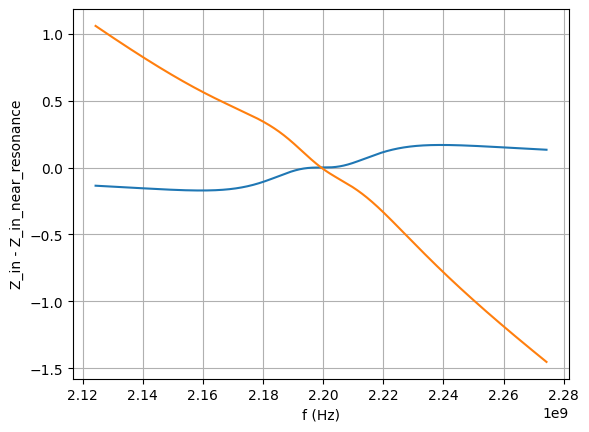

In [38]:
Z_in_diff = Z_in - Z_in_near_resonance

fig, ax = plt.subplots()
ax.plot(f, Z_in_diff.real)
ax.plot(f, Z_in_diff.imag)
ax.set(xlabel='f (Hz)', ylabel='Z_in - Z_in_near_resonance')
ax.grid()

if save:
    plt.savefig("Z_in_diff.png")

---

**g) Traçar a curva de coeficiente de reflexão em dB.**

O valor do coeficiente de reflexão é dado por:

$\vert \Gamma_{in} \vert = \vert \frac{Z_{in} - Z_0}{Z_{in} + Z_0} \vert$

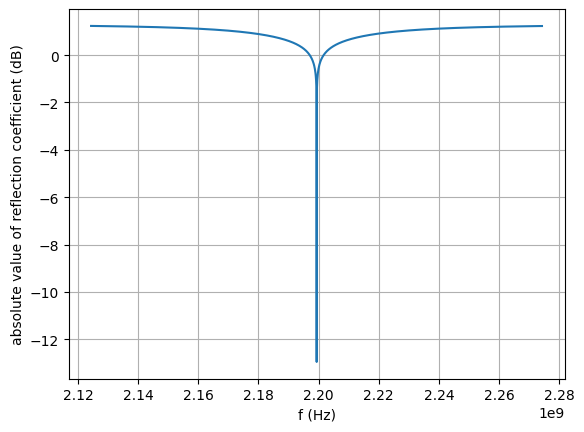

In [41]:
f = np.arange(f0 - 150e6/2, f0 + 150e6/2, 1e5)
w = f * (2*pi)
Z_in = calculate_Z_in(w)

Z0 = 50
def reflection_coefficient(Z_in):
    return np.abs((Z_in - Z0)/(Z_in + Z0))

R_in = reflection_coefficient(Z_in)
R_in_db = np.log10(20 * R_in)

fig, ax = plt.subplots()
ax.plot(f, R_in_db)
ax.set(xlabel='f (Hz)', ylabel='absolute value of reflection coefficient (dB)')
ax.grid()

if save:
    plt.savefig("R_in.png")